In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import model
from model import ProposalLayer
from config import Config
import tensorflow as tf
import keras 
import keras.layers as KL
import keras.models as KM

config = Config()

def generate_random_boxes(num =10):
    x1 = np.random.random([num, 1])
    y1 = np.random.random([num, 1])
    w = np.random.random([num, 1])
    h = np.random.random([num, 1])
    
    x2 = x1 + w/2
    y2 = y1 + h/2
    
    boxes = np.concatenate(np.array([y1, x1, y2, x2]), axis=1)
    return boxes

Using TensorFlow backend.


In [2]:
scale = 1024

# create anchors
anchors = generate_random_boxes(10) * scale
# anchors = np.expand_dims(anchors, axis=0)
print('anchors shape: ', anchors.shape)
# print(anchors)

# create deltas
delta_box = np.random.random([4])
delta_box = np.broadcast_to(delta_box, [10, 4])
print('delta_box shape: ', delta_box.shape)
# print(delta_box)

# create gtdelta_box
boxes = model.apply_deltas_to_boxes(anchors, delta_box, config)
print('boxes shape: ', boxes.shape)

# create scores
scores = np.random.random([1, 10])
print('scores shape: ', scores.shape)



anchors shape:  (10, 4)
delta_box shape:  (10, 4)
boxes shape:  (10, 4)
scores shape:  (1, 10)


In [3]:
anchors = np.expand_dims(anchors, axis=0)
print('anchors shape: ', anchors.shape)

delta_box = np.expand_dims(delta_box, axis=0)
print('delta_box shape: ', delta_box.shape)

boxes = np.expand_dims(boxes, axis=0)
print('boxes shape: ', boxes.shape)

anchors shape:  (1, 10, 4)
delta_box shape:  (1, 10, 4)
boxes shape:  (1, 10, 4)


In [4]:
proposal_count = 5
nms_threshold = 0.3

rpn_class_probs = np.broadcast_to(np.expand_dims(scores, axis=2), [1, 10, 2])
rpn_reg_logits = delta_box
input_anchors = anchors
        
# rpn_class_probs = tf.constant(rpn_class_probs)
# rpn_reg_logits = tf.constant(rpn_reg_logits)
# input_anchors = tf.constant(input_anchors)

dummy_input = KL.Input(shape=(1,1))
rpn_class_probs = KL.Lambda(lambda x: tf.Variable(rpn_class_probs))(dummy_input)
rpn_reg_logits = KL.Lambda(lambda x: tf.Variable(rpn_reg_logits))(dummy_input)
input_anchors = KL.Lambda(lambda x: tf.Variable(input_anchors))(dummy_input)

proposals = ProposalLayer(proposal_count, 
                          nms_threshold, 
                          config,           
                          name='proposal_layer')([rpn_class_probs,
                                                  rpn_reg_logits,
                                                  input_anchors])
Kmodel = KM.Model(dummy_input, proposals)
Kmodel.compile('sgd','binary_crossentropy')

input = np.random.random([1,1,1])
rois = Kmodel.predict(input)

print(rois, rois.shape)

Instructions for updating:
Colocations handled automatically by placer.
[[[ 810.31067  809.08905  899.235   1024.     ]
  [ 258.2124   591.5453   475.40894 1024.     ]
  [ 205.94318   88.72308  323.88     137.7234 ]
  [ 684.3557   742.6277  1024.       804.5142 ]
  [ 495.893    152.19481  757.99115  399.55237]]] (1, 5, 4)


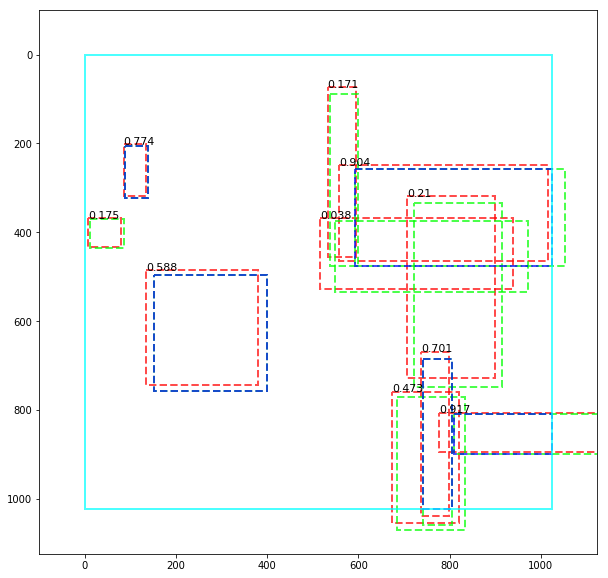

In [8]:
fig, ax = plt.subplots(1 , figsize=(10, 10))
# revese y axi
# ax.set_ylim(ax.get_ylim()[::-1])
delta = 100
ax.set_ylim([scale+delta, 0-delta])
ax.set_xlim([0-delta, scale+delta])
# plot anchors
for i, box in enumerate(anchors[0]):
    y1, x1, y2, x2 = box
    p = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=2,
                          alpha=0.7, 
                          linestyle="dashed",
                          edgecolor=[1,0,0], 
                          facecolor='none')
    ax.add_patch(p)
    
    ax.text(x1, y1, 
        round(scores[0][i], 3),
        color='black', size=11, backgroundcolor="none")
# plot gt_boxes
for i, box in enumerate(boxes[0]):
    y1, x1, y2, x2 = box
    p = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=2,
                          alpha=0.7, 
                          linestyle="dashed",
                          edgecolor=[0,1,0], 
                          facecolor='none')
    ax.add_patch(p)
# plot rois
for i, box in enumerate(rois[0]):
    y1, x1, y2, x2 = box
    p = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=2,
                          alpha=0.7, 
                          linestyle="dashed",
                          edgecolor=[0,0,1], 
                          facecolor='none')
    ax.add_patch(p)
# plot [0,0,1024,1024]
boundary = [0,0,1024,1024]
y1, x1, y2, x2 = boundary
p = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                     linewidth=2,
                      alpha=0.7, 
                      linestyle="solid",
                      edgecolor=[0,1,1], 
                      facecolor='none')
ax.add_patch(p)
    
plt.show()